In [4]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Transactions Data:


<>:4: SyntaxWarning: invalid escape sequence '\P'
<>:5: SyntaxWarning: invalid escape sequence '\P'
<>:4: SyntaxWarning: invalid escape sequence '\P'
<>:5: SyntaxWarning: invalid escape sequence '\P'
C:\Users\shanm\AppData\Local\Temp\ipykernel_15616\585228470.py:4: SyntaxWarning: invalid escape sequence '\P'
  synthetic_dataset_path = "C:\Projects\E-Commerce\synthetic_dataset.csv"
C:\Users\shanm\AppData\Local\Temp\ipykernel_15616\585228470.py:5: SyntaxWarning: invalid escape sequence '\P'
  synthetic_customers_path = "C:\Projects\E-Commerce\synthetic_customers.csv"


,transaction_id,date,customer_id,gender,age,product_category,quantity,price_per_unit,total_amount,_computed_total
0,TXN00001,2023-03-29,CUST001,Male,34,Clothing,4,888,3552,3552
1,TXN00002,2023-05-31,CUST001,Male,34,Clothing,4,838,3352,3352
2,TXN00003,2022-01-17,CUST001,Male,34,Clothing,3,201,603,603
3,TXN00004,2022-02-15,CUST001,Male,34,Clothing,4,229,916,916
4,TXN00005,2024-01-15,CUST001,Male,34,Electronics,5,527,2635,2635


Customer Summary:


,customer_id,Recency,Frequency,Monetary
0,CUST001,109,12,23498
1,CUST002,4,113,162206
2,CUST003,149,1,675
3,CUST004,238,1,2676
4,CUST005,1,58,77527


,customer_id,Recency,Frequency,Monetary
0,CUST001,109,12,23498
1,CUST002,4,113,162206
2,CUST003,149,1,675
3,CUST004,238,1,2676
4,CUST005,1,58,77527


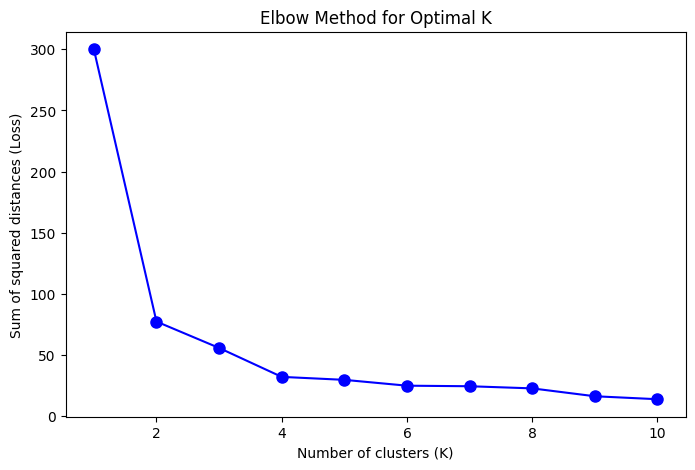

Centroids (original scale):
    Recency  Frequency   Monetary
0  2.085800   4.215434  11.555612
1  3.843214   2.155821   9.235424
2  1.104285   5.809182  13.132728
3  5.650861   0.770571   7.144899


,Recency,Frequency,Monetary,Size
Cluster,,,,
0,9.458333,73.458333,114093.208333,24
1,72.962963,8.962963,13107.444444,27
2,2.285714,379.047619,575583.523810,21
3,361.035714,1.250000,1856.250000,28


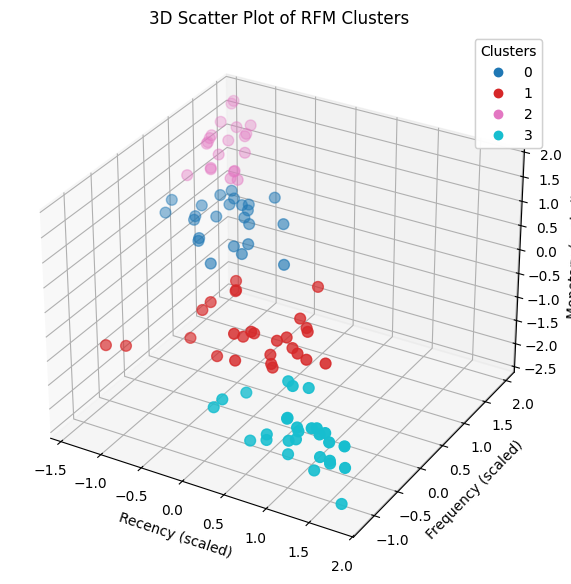

In [ ]:
import pandas as pd

# Specify paths to your saved files
synthetic_dataset_path = "C:\Projects\E-Commerce\notebooks\synthetic_dataset.csv"
synthetic_customers_path = "C:\Projects\E-Commerce\notebooks\synthetic_customers.csv"

# Load datasets
df_transactions = pd.read_csv(synthetic_dataset_path)
df_customers = pd.read_csv(synthetic_customers_path)

# Inspect first few rows
print("Transactions Data:")
display(df_transactions.head())

print("Customer Summary:")
display(df_customers.head())
# -------------------------------
#Ensure RFM Table is Correct
# -------------------------------
# Convert date column to datetime
df_transactions['date'] = pd.to_datetime(df_transactions['date'])

# Snapshot date = day after last transaction
snapshot_date = df_transactions['date'].max() + pd.Timedelta(days=1)

# Compute RFM
rfm = df_transactions.groupby('customer_id').agg({
    'date': lambda x: (snapshot_date - x.max()).days,  # Recency
    'transaction_id': 'nunique',                       # Frequency
    'total_amount': 'sum'                              # Monetary
}).reset_index()

# Rename columns
rfm.rename(columns={'date':'Recency','transaction_id':'Frequency','total_amount':'Monetary'}, inplace=True)

display(rfm.head())
# -------------------------------
# Scaling
# --------------------------------
# Example: scaling
from sklearn.preprocessing import StandardScaler
import numpy as np

rfm_log = rfm.copy()
rfm_log['Recency'] = np.log1p(rfm_log['Recency'])
rfm_log['Frequency'] = np.log1p(rfm_log['Frequency'])
rfm_log['Monetary'] = np.log1p(rfm_log['Monetary'])

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log[['Recency','Frequency','Monetary']])

# -------------------------------
# K-Means from Scratch on RFM Data
# -------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# --- Step 0: Load your RFM table ---
# Assume rfm is your DataFrame with columns ['Recency', 'Frequency', 'Monetary']
# rfm = pd.read_csv("rfm_table.csv")  # if needed

# --- Step 1: Log-transform skewed features ---
rfm_log = rfm.copy()
rfm_log['Recency'] = np.log1p(rfm_log['Recency'])
rfm_log['Frequency'] = np.log1p(rfm_log['Frequency'])
rfm_log['Monetary'] = np.log1p(rfm_log['Monetary'])

# --- Step 2: Standardize features ---
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log[['Recency','Frequency','Monetary']])

# --- Step 3: K-Means function ---
def kmeans_scratch(X, K, max_iters=100, tol=1e-4, seed=42):
    np.random.seed(seed)
    n_samples, n_features = X.shape
    # Initialize centroids randomly
    centroids = X[np.random.choice(n_samples, K, replace=False)]
    
    for iteration in range(max_iters):
        # Compute distances to centroids
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)  # (n_samples, K)
        labels = np.argmin(distances, axis=1)
        
        # Update centroids
        new_centroids = np.array([
            X[labels == k].mean(axis=0) if np.any(labels==k) else centroids[k]
            for k in range(K)
        ])
        
        # Check for convergence
        if np.all(np.linalg.norm(new_centroids - centroids, axis=1) < tol):
            break
        
        centroids = new_centroids
    
    # Compute final loss (sum of squared distances)
    loss = sum(np.sum((X[labels == k] - centroids[k])**2) for k in range(K))
    
    return labels, centroids, loss

# --- Step 4: Elbow Method ---
losses = []
K_range = range(1, 11)
for k in K_range:
    _, _, loss = kmeans_scratch(rfm_scaled, K=k)
    losses.append(loss)

plt.figure(figsize=(8,5))
plt.plot(K_range, losses, 'bo-', markersize=8)
plt.xlabel("Number of clusters (K)")
plt.ylabel("Sum of squared distances (Loss)")
plt.title("Elbow Method for Optimal K")
plt.show()

# --- Step 5: Run K-Means with chosen K ---
optimal_K = 4  # choose based on elbow
labels, centroids, final_loss = kmeans_scratch(rfm_scaled, K=optimal_K)

# Assign clusters to original RFM table
rfm['Cluster'] = labels

# --- Step 6: Transform centroids back to original scale ---
centroids_unscaled = centroids * rfm_log[['Recency','Frequency','Monetary']].std().values + \
                     rfm_log[['Recency','Frequency','Monetary']].mean().values

print("Centroids (original scale):")
print(pd.DataFrame(centroids_unscaled, columns=['Recency','Frequency','Monetary']))

# --- Step 7: Summary per cluster ---
cluster_summary = rfm.groupby('Cluster')[['Recency','Frequency','Monetary']].mean()
cluster_summary['Size'] = rfm.groupby('Cluster').size()
display(cluster_summary)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Use the scaled RFM features for plotting
x = rfm_scaled[:,0]  # Recency (scaled)
y = rfm_scaled[:,1]  # Frequency (scaled)
z = rfm_scaled[:,2]  # Monetary (scaled)
clusters = rfm['Cluster'].values

# Create 3D scatter plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

# Plot points
scatter = ax.scatter(x, y, z, c=clusters, cmap='tab10', s=60)

# Add labels
ax.set_xlabel('Recency (scaled)')
ax.set_ylabel('Frequency (scaled)')
ax.set_zlabel('Monetary (scaled)')
ax.set_title('3D Scatter Plot of RFM Clusters')

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()


K vs Loss Table:


,K,Sum_of_Squared_Distances
0,1,300.000000
1,2,77.413036
2,3,55.854959
3,4,32.203928
4,5,29.773087
5,6,25.006597
6,7,24.553508
7,8,22.799536
8,9,16.367934
9,10,13.942401


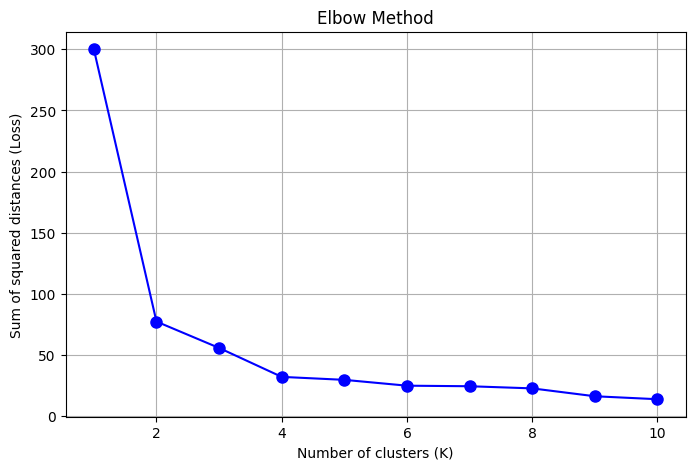

K vs Loss vs Loss Reduction:


,K,Sum_of_Squared_Distances,Loss_Reduction
0,1,300.000000,222.586964
1,2,77.413036,21.558077
2,3,55.854959,23.651031
3,4,32.203928,2.430840
4,5,29.773087,4.766491
5,6,25.006597,0.453089
6,7,24.553508,1.753972
7,8,22.799536,6.431602
8,9,16.367934,2.425533
9,10,13.942401,0.000000


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Assume rfm_scaled is already prepared ---
# rfm_scaled: standardized & log-transformed RFM features

# Step 1: Compute K vs Loss
losses = []
K_range = range(1, 11)

for k in K_range:
    labels, centroids, loss = kmeans_scratch(rfm_scaled, K=k)
    losses.append(loss)

# Step 2: Create table
k_loss_table = pd.DataFrame({
    "K": K_range,
    "Sum_of_Squared_Distances": losses
})

print("K vs Loss Table:")
display(k_loss_table)

# Step 3: Plot elbow curve
plt.figure(figsize=(8,5))
plt.plot(K_range, losses, 'bo-', markersize=8)
plt.xlabel("Number of clusters (K)")
plt.ylabel("Sum of squared distances (Loss)")
plt.title("Elbow Method")
plt.grid(True)
plt.show()

# Step 4: Optional - compute derivative (loss reduction per cluster)
k_loss_table['Loss_Reduction'] = k_loss_table['Sum_of_Squared_Distances'].diff(-1).fillna(0)
print("K vs Loss vs Loss Reduction:")
display(k_loss_table)



Cluster Summary Table (Mean, Std, Size):


,Recency,Frequency,Monetary,Recency_std,Frequency_std,Monetary_std,Size
Cluster,,,,,,,
0,9.458333,73.458333,114093.208333,8.576911,32.371457,49266.910977,24
1,72.962963,8.962963,13107.444444,63.222125,5.977403,9319.673609,27
2,2.285714,379.047619,575583.523810,1.309307,220.756308,332211.893433,21
3,361.035714,1.250000,1856.250000,233.433547,0.645497,1662.228861,28


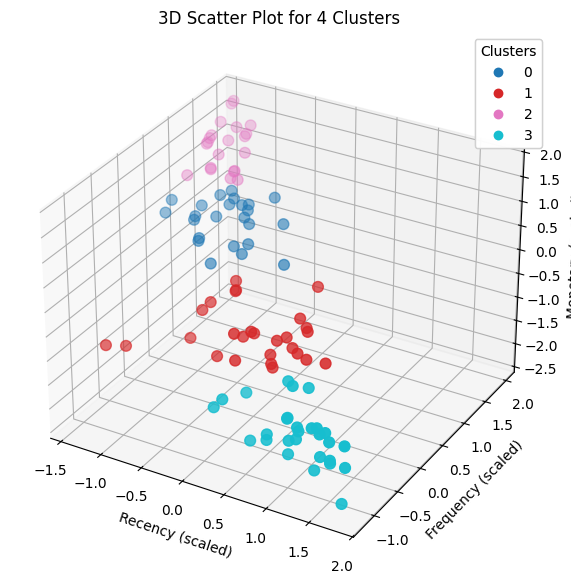

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

# --- Assume rfm DataFrame is ready ---
# rfm columns: ['customer_id','Recency','Frequency','Monetary']

# --- Step 0: Log + Scale ---
rfm_log = rfm.copy()
rfm_log['Recency'] = np.log1p(rfm_log['Recency'])
rfm_log['Frequency'] = np.log1p(rfm_log['Frequency'])
rfm_log['Monetary'] = np.log1p(rfm_log['Monetary'])

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log[['Recency','Frequency','Monetary']])

# --- Step 1: K-Means from scratch ---
def kmeans_scratch(X, K, max_iters=100, tol=1e-4, seed=42):
    np.random.seed(seed)
    n_samples, n_features = X.shape
    centroids = X[np.random.choice(n_samples, K, replace=False)]
    
    for iteration in range(max_iters):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        
        new_centroids = np.array([
            X[labels == k].mean(axis=0) if np.any(labels==k) else centroids[k]
            for k in range(K)
        ])
        if np.all(np.linalg.norm(new_centroids - centroids, axis=1) < tol):
            break
        centroids = new_centroids
    
    return labels, centroids

# --- Step 2: User input for number of clusters ---
K_input = int(input("Enter number of clusters: "))

labels, centroids = kmeans_scratch(rfm_scaled, K=K_input)
rfm['Cluster'] = labels

# --- Step 3: Cluster summary table with mean, std, and size ---
cluster_mean = rfm.groupby('Cluster')[['Recency','Frequency','Monetary']].mean()
cluster_std = rfm.groupby('Cluster')[['Recency','Frequency','Monetary']].std()
cluster_size = rfm.groupby('Cluster').size()

cluster_summary = cluster_mean.copy()
cluster_summary[['Recency_std','Frequency_std','Monetary_std']] = cluster_std
cluster_summary['Size'] = cluster_size
cluster_summary = cluster_summary.sort_index()

print("\nCluster Summary Table (Mean, Std, Size):")
display(cluster_summary)

# --- Step 4: 3D Scatter plot ---
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

x = rfm_scaled[:,0]  # Recency
y = rfm_scaled[:,1]  # Frequency
z = rfm_scaled[:,2]  # Monetary

scatter = ax.scatter(x, y, z, c=labels, cmap='tab10', s=60)

ax.set_xlabel('Recency (scaled)')
ax.set_ylabel('Frequency (scaled)')
ax.set_zlabel('Monetary (scaled)')
ax.set_title(f'3D Scatter Plot for {K_input} Clusters')

legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()
